In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle
import qnmfits
import utils

from cmcrameri import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)
t0_E = pd.read_csv('../data/t0N_E.csv', index_col=0)

In [3]:
ID = 1
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

In [4]:
t0 = t0_E[str(ID)].values[10]
t0

np.float64(-1.87500921076753)

In [5]:
N_max = 15
mode_list = utils.get_mode_list(N_max)

# Choose list of delta values that we are interested in 
delta_list = [0.0, 0.01, 0.05, 0.2]

epsilon_dict_all = {delta: [] for delta in delta_list}
epsilon_dict_target = {delta: [] for delta in delta_list}

for d in delta_list:


    # Modify all overtones
    # --------------------

    # Iterate through mode lists with different values of N
    for i, modes in enumerate(mode_list):

        delta = [0] + i*[d]

        # Calculate epsilon and add it to a list
        epsilon_dict_all[d].append(
            qnmfits.calculate_epsilon(
                sim.times,
                sim.h[2,2],
                modes,
                Mf,
                chif,
                t0=t0,
                t0_method='closest',
                delta=delta
            )[0]
        )

    # Modify only the first overtone
    # ------------------------------

    # Iterate through mode lists with different values of N
    for i, modes in enumerate(mode_list):

        if i == 0:
            delta = [0]
        else:
            delta = [0] + [d] + (i-1)*[0]

        # Calculate epsilon and add it to a list
        epsilon_dict_target[d].append(
            qnmfits.calculate_epsilon(
                sim.times,
                sim.h[2,2],
                modes,
                Mf,
                chif,
                t0=t0,
                t0_method='closest',
                delta=delta
            )[0]
        )


In [6]:
def get_color(d):
    if d == 0.0:
        color = 'C7'
    elif d==0.01:
        color = cm.managua(.0)
    elif d==0.05:
        color = cm.managua(.33)
    else:
        color = cm.managua(.66)
    return color

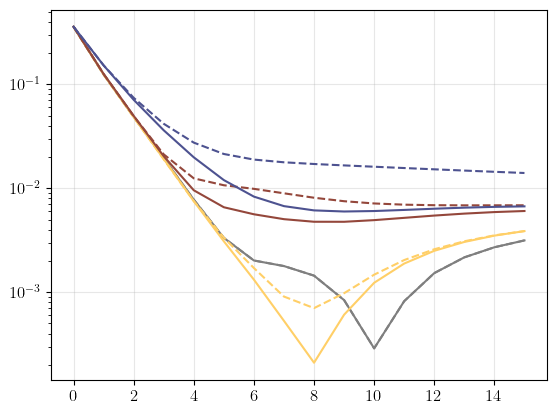

In [7]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid(alpha=0.3)

for d in delta_list:

    ax.plot(
        range(len(epsilon_dict_all[d])), 
        epsilon_dict_all[d], 
        label=f'$\delta = {d}$', 
        c=get_color(d), 
        # marker='o', 
        linestyle='--'
    )
    
    ax.plot(
        range(len(epsilon_dict_target[d])), 
        epsilon_dict_target[d], 
        label=f'$\delta = {d}$ target', 
        c=get_color(d), 
        # marker='^', 
        linestyle='-'
    )

In [8]:
N_max = 15
mode_list = utils.get_mode_list(N_max)

# Choose list of delta values that we are interested in 
delta_list = [0.0, 0.01, 0.05, 0.2]

epsilon_dict_all = {delta: [] for delta in delta_list}
epsilon_dict_target = {delta: [] for delta in delta_list}

for d in delta_list:

    # Iterate through mode lists with different values of N
    for i, modes in enumerate(mode_list):

        delta = [0] + i*[d] + [0]

        # Calculate epsilon and add it to a list
        epsilon_dict_all[d].append(
            qnmfits.calculate_epsilon(
                sim.times,
                sim.h[2,2],
                modes + [(3,2,0,1)],
                Mf,
                chif,
                t0=t0,
                t0_method='closest',
                delta=delta
            )[0]
        )

    # Iterate through mode lists with different values of N
    for i, modes in enumerate(mode_list):

        if i == 0:
            delta = [0] + [0]
        else:
            delta = [0] + [d] + (i-1)*[0] + [0]

        # Calculate epsilon and add it to a list
        epsilon_dict_target[d].append(
            qnmfits.calculate_epsilon(
                sim.times,
                sim.h[2,2],
                modes + [(3,2,0,1)],
                Mf,
                chif,
                t0=t0,
                t0_method='closest',
                delta=delta
            )[0]
        )


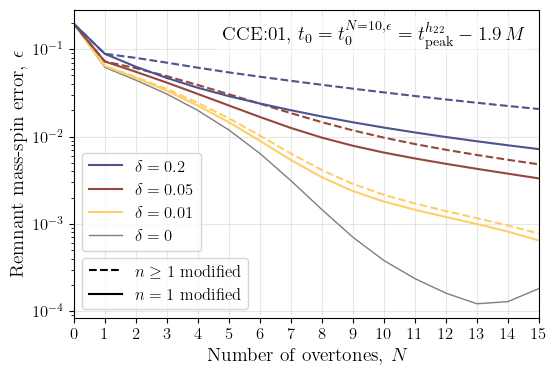

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

for d in delta_list:

    if d == 0.0:

        ax.plot(
            range(len(epsilon_dict_all[d])), 
            epsilon_dict_all[d], 
            c=get_color(d), 
            linestyle='-',
            lw=1
        )

    else:

        ax.plot(
            range(len(epsilon_dict_all[d])), 
            epsilon_dict_all[d], 
            c=get_color(d), 
            linestyle='--'
        )
        
        ax.plot(
            range(len(epsilon_dict_target[d])), 
            epsilon_dict_target[d], 
            c=get_color(d), 
            linestyle='-'
        )

text = ax.text(
    0.97, 
    0.9, 
    f'CCE:{ID:02}, $t_0 = t_0^{{N=10, \epsilon}} = t_\mathrm{{peak}}^{{h_{{22}}}} {t0:.1f}\,M$',
    transform=ax.transAxes,
    horizontalalignment='right',
    )
text.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax.set_xlim(0,15)

ax.set_xlabel('Number of overtones, $N$')
ax.set_ylabel('Remnant mass-spin error, $\epsilon$')

ax.set_xticks(range(0,16))

custom_lines = [
    mpl.lines.Line2D([0], [0], color='k', linestyle='--'),
    mpl.lines.Line2D([0], [0], color='k', linestyle='-')
]
custom_labels = ['$n \geq 1$ modified', '$n = 1$ modified']

l1 = ax.legend(
    custom_lines, 
    custom_labels, 
    loc='lower left'
    )

fig.add_artist(l1)

custom_lines = [
    mpl.lines.Line2D([0], [0], color=cm.managua(.66), linestyle='-'),
    mpl.lines.Line2D([0], [0], color=cm.managua(.33), linestyle='-'),
    mpl.lines.Line2D([0], [0], color=cm.managua(.0), linestyle='-'),
    mpl.lines.Line2D([0], [0], color='C7', linestyle='-', lw=1)
]
custom_labels = [
    '$\delta = 0.2$', '$\delta = 0.05$', '$\delta = 0.01$', '$\delta = 0$'
]

ax.legend(
    custom_lines, 
    custom_labels, 
    loc='lower left',
    bbox_to_anchor=(0, 0.19)
    );

In [10]:
delta_zero_curves = {}

for ID_i in t0_E.columns:
    
    sim_info = utils.load_cce_data(int(ID_i))
    sim = sim_info['sim']
    chif = sim.chif_mag
    Mf = sim.Mf

    t0 = t0_E[ID_i].values[10]

    N_max = 20
    mode_list = utils.get_mode_list(N_max)

    delta_zero_curves[ID_i] = []

    # Iterate through mode lists with different values of N
    for i, modes in enumerate(mode_list):

        # Calculate epsilon and add it to a list
        delta_zero_curves[ID_i].append(
            qnmfits.calculate_epsilon(
                sim.times,
                sim.h[2,2],
                modes + [(3,2,0,1)],
                Mf,
                chif,
                t0=t0,
                t0_method='closest',
            )[0]
        )

In [11]:
N_list = list(range(21))
N_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

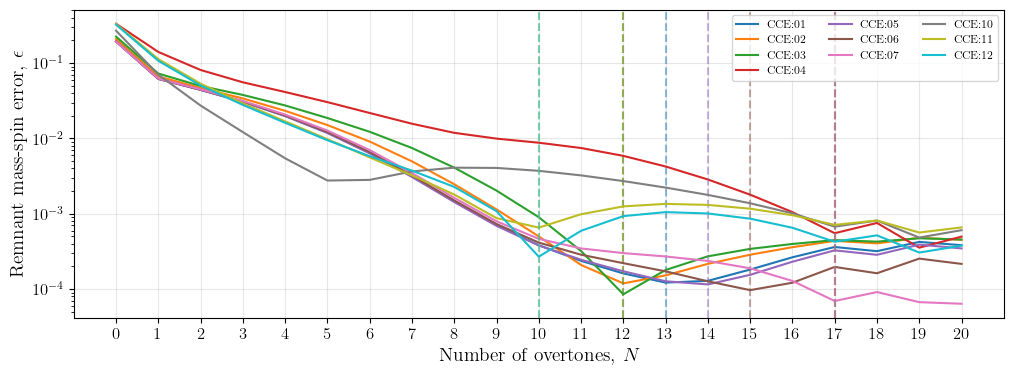

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set_yscale('log')
ax.grid(alpha=0.3)

Nfit_dict = {}

for i, ID_i in enumerate(t0_E.columns):
    
    ax.plot(
        N_list, 
        delta_zero_curves[ID_i], 
        c=f'C{i}',
        label=f'CCE:{int(ID_i):02}'
    )

    current_eps = delta_zero_curves[ID_i][9]
    for eps in delta_zero_curves[ID_i][9:]:
        if eps > current_eps:
            break
        else:
            current_eps = eps
    N_min = N_list[delta_zero_curves[ID_i].index(current_eps)]
    ax.axvline(N_min, linestyle='--', color=f'C{i}', alpha=0.5)
    Nfit_dict[ID_i] = N_min

ax.set_xlabel('Number of overtones, $N$')
ax.set_ylabel('Remnant mass-spin error, $\epsilon$')

ax.set_xticks(N_list)

ax.legend(loc='upper right', ncol=3, fontsize=8);

In [13]:
Nfit_dict

{'1': 13,
 '2': 12,
 '3': 12,
 '4': 17,
 '5': 14,
 '6': 15,
 '7': 17,
 '10': 17,
 '11': 10,
 '12': 10}

In [14]:
delta_list_dense = np.linspace(0, 0.2, 100)

In [ ]:
epsilon_catalog_dict = {}

for ID_i in t0_E.columns:

    sim_info = utils.load_cce_data(int(ID_i))
    sim = sim_info['sim']
    chif = sim.chif_mag
    Mf = sim.Mf

    N = Nfit_dict[ID_i]
    modes = [(2, 2, n, 1) for n in range(N+1)] + [(3,2,0,1)]
    t0 = t0_E[ID_i].values[10]

    epsilon_dict = {}

    for ntilde in range(N+1):
        epsilon_dict[ntilde] = []
        for delta in delta_list_dense:
            frequency_deltas = np.zeros(len(modes))
            frequency_deltas[ntilde] = delta
            epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
                times=sim.times,
                data=sim.h[2,2], 
                modes=modes,
                Mf=sim.Mf, 
                chif=sim.chif_mag, 
                t0=t0,
                t0_method='closest',
                T=100,
                delta=frequency_deltas
            )
            epsilon_dict[ntilde].append(epsilon)

    epsilon_catalog_dict[ID_i] = epsilon_dict 

In [ ]:
# with open('../data/epsilon_catalog_dict.pkl', 'wb') as f:
#     pickle.dump(epsilon_catalog_dict, f)

In [15]:
with open('../data/epsilon_catalog_dict.pkl', 'rb') as f:
    epsilon_catalog_dict = pickle.load(f)

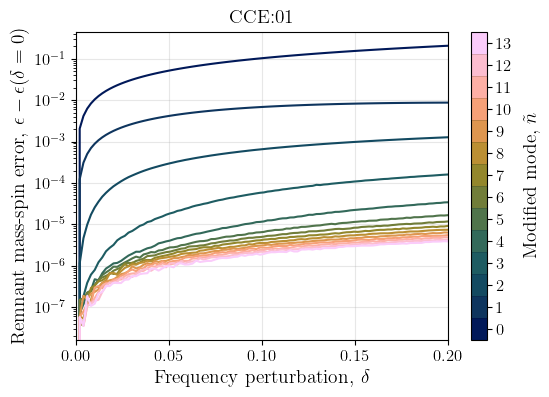

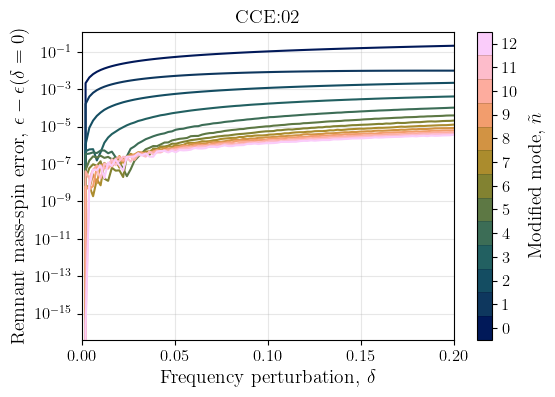

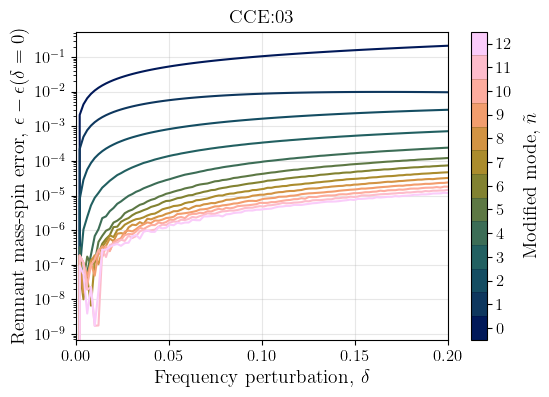

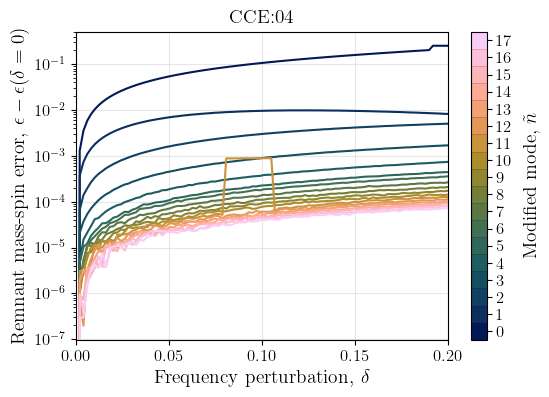

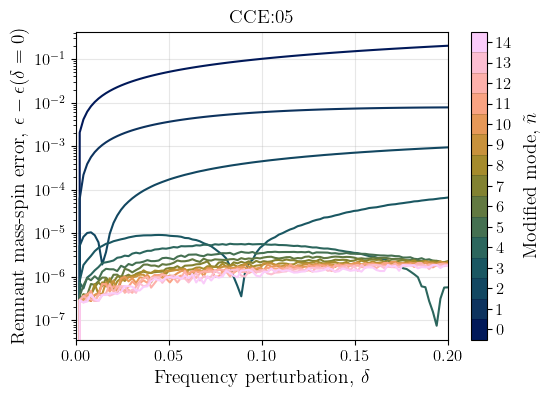

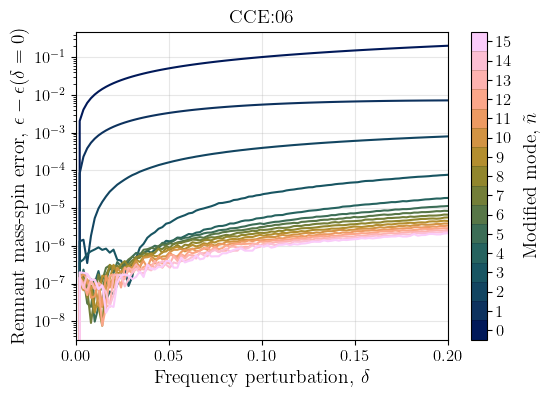

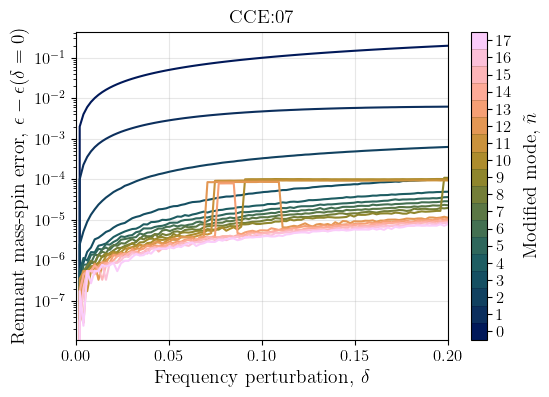

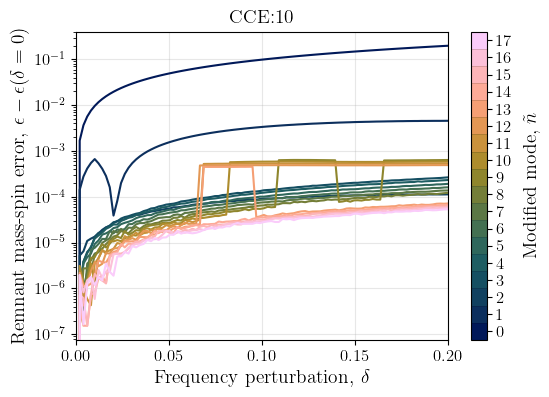

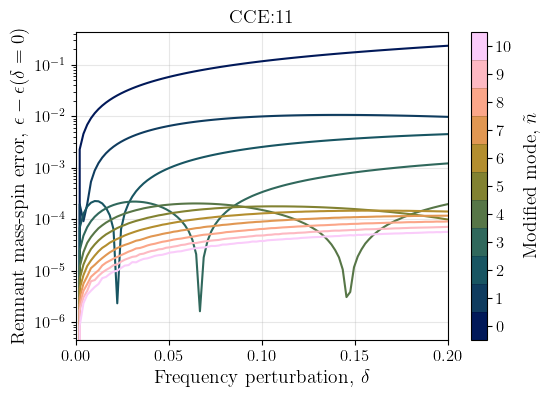

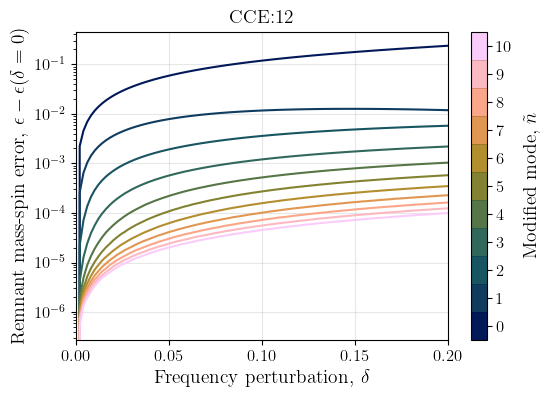

In [16]:
for ID_i in epsilon_catalog_dict.keys():

    ID_i = str(ID_i)
    N = Nfit_dict[ID_i]

    nt_min = 0
    nt_max = N
    nt_list = list(range(nt_min,nt_max+1))

    # Create a custom colormap
    color_list = [cm.batlow(N/nt_max) for N in nt_list]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        None, color_list, N=len(color_list)
        )

    norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_yscale('log')

    ax.grid(visible=True, alpha=0.3)

    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax, 
        ticks=range(nt_min, nt_max+1),
        )

    cbar.set_label(r'Modified mode, $\tilde n$', labelpad=7)

    bounds = [n+0.5 for n in range(nt_min, nt_max)]
    for bound in bounds:
        cbar.ax.axhline(bound, color='k', lw=0.5, alpha=0.2)

    for ntilde in range(nt_max+1):
        ax.plot(
            delta_list_dense, 
            #  epsilon_catalog_dict[ID_i][ntilde] - epsilon_catalog_dict[ID_i][ntilde][0], 
            abs(epsilon_catalog_dict[ID_i][ntilde] - epsilon_catalog_dict[ID_i][ntilde][0]), 
            color=cmap(ntilde)
        )
    ax.set_xlabel(r'Frequency perturbation, $\delta$')
    ax.set_ylabel('Remnant mass-spin error, $\epsilon - \epsilon(\delta = 0)$')

    ax.set_xlim(0, 0.2)

    ax.set_title(f'CCE:{int(ID_i):02}')

    # ax.tick_params(axis='x', labelsize=14)
    # ax.tick_params(axis='y', labelsize=14)

In [17]:
delta_star = 0.05
index = np.argmin(np.abs(delta_list_dense - delta_star))

epsilon_star_dict = {}

for ID_i in epsilon_catalog_dict.keys():

    epsilon_dict = epsilon_catalog_dict[ID_i]
    N = Nfit_dict[ID_i]

    epsilon_star_dict[ID_i] = []

    for ntilde in range(N+1):
        epsilon_star_dict[ID_i].append(epsilon_dict[ntilde][index] - epsilon_dict[ntilde][0])

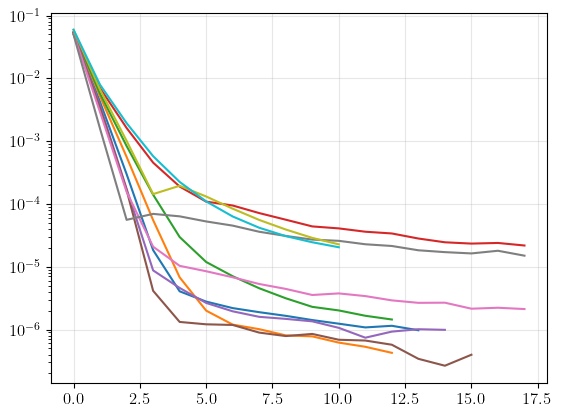

In [18]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid(alpha=0.3)

for ID_i in epsilon_star_dict.keys():

    epsilon_star = epsilon_star_dict[ID_i]
    N = Nfit_dict[ID_i]
    nt_list = list(range(N+1))

    ax.plot(
        nt_list,
        np.abs(epsilon_star),
    )

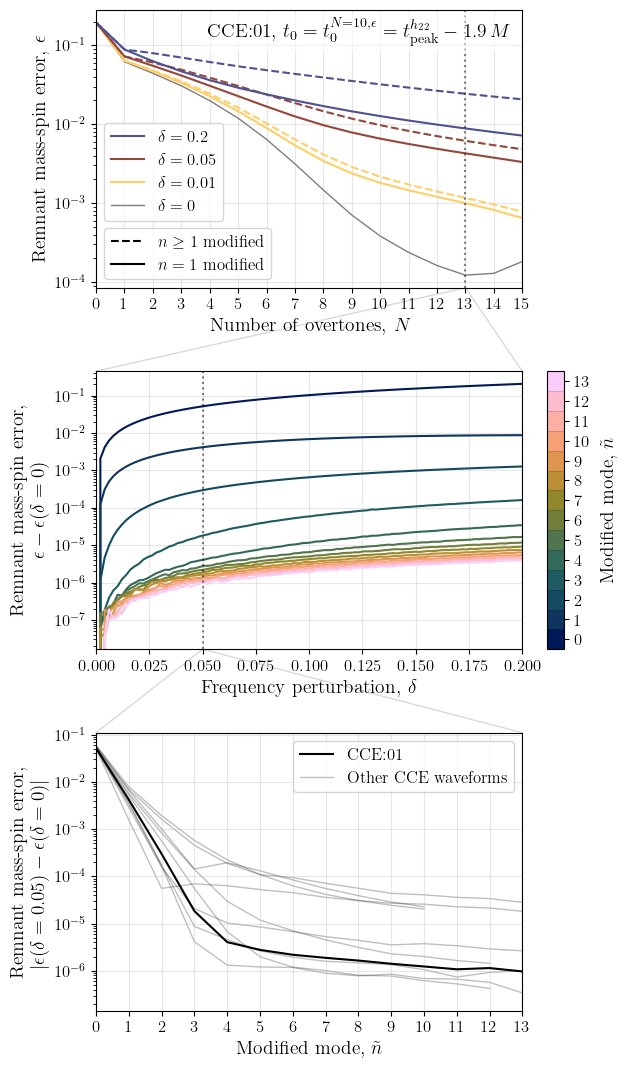

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(5.5,13))
fig.subplots_adjust(hspace=0.3)

for ax in axs:
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

# epsilon vs N
# ------------

ID = 1
t0 = t0_E[str(ID)].values[10]

for d in delta_list:

    if d == 0.0:

        axs[0].plot(
            range(len(epsilon_dict_all[d])), 
            epsilon_dict_all[d], 
            c=get_color(d), 
            linestyle='-',
            lw=1
        )

    else:

        axs[0].plot(
            range(len(epsilon_dict_all[d])), 
            epsilon_dict_all[d], 
            c=get_color(d), 
            linestyle='--'
        )
        
        axs[0].plot(
            range(len(epsilon_dict_target[d])), 
            epsilon_dict_target[d], 
            c=get_color(d), 
            linestyle='-'
        )

text = axs[0].text(
    0.97, 
    0.9, 
    f'CCE:{ID:02}, $t_0 = t_0^{{N=10, \epsilon}} = t_\mathrm{{peak}}^{{h_{{22}}}} {t0:.1f}\,M$',
    transform=axs[0].transAxes,
    horizontalalignment='right',
    )
text.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))

axs[0].set_xlim(0,15)

axs[0].set_xlabel('Number of overtones, $N$')
axs[0].set_ylabel('Remnant mass-spin error, $\epsilon$')

axs[0].set_xticks(range(0,16))

custom_lines = [
    mpl.lines.Line2D([0], [0], color='k', linestyle='--'),
    mpl.lines.Line2D([0], [0], color='k', linestyle='-')
]
custom_labels = ['$n \geq 1$ modified', '$n = 1$ modified']

l1 = axs[0].legend(
    custom_lines, 
    custom_labels, 
    loc='lower left'
    )

fig.add_artist(l1)

custom_lines = [
    mpl.lines.Line2D([0], [0], color=cm.managua(.66), linestyle='-'),
    mpl.lines.Line2D([0], [0], color=cm.managua(.33), linestyle='-'),
    mpl.lines.Line2D([0], [0], color=cm.managua(.0), linestyle='-'),
    mpl.lines.Line2D([0], [0], color='C7', linestyle='-', lw=1)
]
custom_labels = [
    '$\delta = 0.2$', '$\delta = 0.05$', '$\delta = 0.01$', '$\delta = 0$'
]

axs[0].legend(
    custom_lines, 
    custom_labels, 
    loc='lower left',
    bbox_to_anchor=(0, 0.21)
    )

axs[0].axvline(13, linestyle=':', color='k', alpha=0.5)

# epsilon vs delta
# ----------------

nt_min = 0
nt_max = Nfit_dict[str(ID)]
nt_list = list(range(nt_min,nt_max+1))

color_list = [cm.batlow(N/nt_max) for N in nt_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

# cbar = fig.colorbar(
#     mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#     ax=axs[1], 
#     ticks=range(nt_min, nt_max+1),
#     )

# cbar = fig.colorbar(
#     mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#     ax=axs,
#     location='right',
#     ticks=range(nt_min, nt_max+1),
#     shrink=0.29,
#     # aspect=25,
# )

cax = inset_axes(
    axs[1],
    width="4%",
    height="100%",
    loc='center right',
    borderpad=-2.5
)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    ticks=range(nt_min, nt_max+1),
    )

cbar.set_label(r'Modified mode, $\tilde n$', labelpad=7)

bounds = [n+0.5 for n in range(nt_min, nt_max)]
for bound in bounds:
    cbar.ax.axhline(bound, color='k', lw=0.5, alpha=0.2)

for ntilde in range(nt_max+1):
    axs[1].plot(
        delta_list_dense, 
        epsilon_catalog_dict[str(ID)][ntilde] - epsilon_catalog_dict[str(ID)][ntilde][0], 
        #  abs(epsilon_catalog_dict[ID][ntilde] - epsilon_catalog_dict[ID][ntilde][0]), 
        color=cmap(ntilde)
    )
axs[1].set_xlabel(r'Frequency perturbation, $\delta$')
axs[1].set_ylabel('Remnant mass-spin error, \n$\epsilon - \epsilon(\delta = 0)$')

axs[1].set_xlim(0, 0.2)

axs[1].axvline(0.05, linestyle=':', color='k', alpha=0.5)

# epsilon_star vs ntilde
# ----------------------

for IDi in epsilon_star_dict.keys():

    epsilon_star = epsilon_star_dict[IDi]
    N = Nfit_dict[IDi]
    nt_list = list(range(N+1))

    if IDi == '1':
        c = 'k'
        zorder = 2
        alpha = 1
        lw = 1.5
    else:
        c = 'k'
        zorder = 1
        alpha = 0.25
        lw = 1


    axs[2].plot(
        nt_list,
        np.abs(epsilon_star),
        c=c,
        zorder=zorder,
        alpha=alpha,
        lw=lw
    )

axs[2].set_xlabel(r'Modified mode, $\tilde n$')
axs[2].set_ylabel('Remnant mass-spin error, \n$|\epsilon(\delta = 0.05) - \epsilon(\delta = 0)|$')

axs[2].set_xticks(range(0,16))
axs[2].set_xlim(0,13)

custom_handles = [
    mpl.lines.Line2D([0], [0], color='k', lw=1.5),
    mpl.lines.Line2D([0], [0], color='k', lw=1, alpha=0.25)
]
custom_labels = [
    'CCE:01', 
    'Other CCE waveforms'
]
axs[2].legend(
    custom_handles, 
    custom_labels, 
    loc='upper right',
    # fontsize=8
    )

# ---

ylim_0 = axs[0].get_ylim()

fig.add_artist(
    ConnectionPatch(
        xyA=(13,ylim_0[0]), 
        coordsA=axs[0].transData, 
        xyB=(0,1), 
        coordsB=axs[1].transAxes,
        color='k',
        alpha=0.15,
        zorder=0.
        )
    )

fig.add_artist(
    ConnectionPatch(
        xyA=(13,ylim_0[0]), 
        coordsA=axs[0].transData, 
        xyB=(1,1), 
        coordsB=axs[1].transAxes,
        color='k',
        alpha=0.15,
        zorder=0.
        )
    )

ylim_1 = axs[1].get_ylim()

fig.add_artist(
    ConnectionPatch(
        xyA=(0.05,ylim_1[0]), 
        coordsA=axs[1].transData, 
        xyB=(0,1), 
        coordsB=axs[2].transAxes,
        color='k',
        alpha=0.15,
        zorder=0.
        )
    )

fig.add_artist(
    ConnectionPatch(
        xyA=(0.05,ylim_1[0]), 
        coordsA=axs[1].transData, 
        xyB=(1,1), 
        coordsB=axs[2].transAxes,
        color='k',
        alpha=0.15,
        zorder=0.
        )
    )

fig.savefig('figures/frequency_perturbations.pdf', bbox_inches='tight')